In [1]:
# Libraries
import BondGraphTools as bgt
import matplotlib.pyplot as plt
from cycler import cycler
import numpy as np
import matplotlib.colors
from pylab import rcParams
import rdflib
from lxml import etree
import pandas
import re
import xml.etree.ElementTree as ET
import copy
import difflib
import os
import collections
from collections import Counter

FMA = pandas.read_csv('FMA.csv')
CHEBI = pandas.read_csv('CHEBI.csv')
OPB = pandas.read_csv('OPB.csv')
GO = pandas.read_csv('GO.csv')


fmaID = FMA['Class ID']
fmaLabel= FMA['Preferred Label']
chebiID = CHEBI['Class ID']
chebiLabel= CHEBI['Preferred Label']
opbID = OPB['Class ID']
opbLabel= OPB['Preferred Label']
goID = GO['Class ID']
goLabel= GO['Preferred Label']

c:\users\nsha457\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (41,71,75,77,99,100,103,113,114,138,140,156,157,158,178,198) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
c:\users\nsha457\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
c:\users\nsha457\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (11,12,43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


/Users/nsha457/Documents/Jupyter_files/Annot_Merging/MAPK cascade/MAPK_L1.cellml
/Users/nsha457/Documents/Jupyter_files/Annot_Merging/MAPK cascade/MAPK_L2.cellml

In [2]:
def catRecognition():
    
    print('Please select the category of the models according to the following list:')
    
    print('\n')
    print('MAPK ==> insert "m"')

    print('\n')
    
    
    category=[]
    address=[]
    
    def askForMore(cat,add):
        
        c=input('Enter the category of the model : ')
        c=difflib.get_close_matches(c, ['m'])
        cat.append(c)
        
        add.append(input('Enter the location address for the corresponding file : '))
        
        more=input('More reactions?(Y/N)')
     
        if more.lower() == 'y':
            [cat,add] = askForMore(cat,add)

        elif more.lower() != 'y':
            return [cat,add]        

    askForMore(category,address)

    return [category,address]

In [3]:
# Here, the category of each reaction is asked along with the file location. Enter the location of the cellml file 
# similar to the ones above (Markdown Cell)
[categories,addresses]=catRecognition()

Please select the category of the models according to the following list:


MAPK ==> insert "m"


Enter the category of the model : m
Enter the location address for the corresponding file : /Users/nsha457/Documents/Jupyter_files/Annot_Merging/MAPK cascade/MAPK_L1.cellml
More reactions?(Y/N)y
Enter the category of the model : m
Enter the location address for the corresponding file : /Users/nsha457/Documents/Jupyter_files/Annot_Merging/MAPK cascade/MAPK_L2.cellml
More reactions?(Y/N)n


In [4]:
def getAnnotations(add):
    parser = etree.XMLParser(recover=True)
    root = etree.parse(add, parser).getroot()
    rdfGraph = rdflib.Graph()
    for rdfElement in root.iter():
        if rdfElement.tag.endswith('RDF'):
            try:
                rdfGraph.parse(data = etree.tostring(rdfElement))
            except:
                pass
            
    def getLeaves(sbj, graph):
        triples = list(graph.triples((sbj,None,None)))
        leaves = []
        if len(triples)>0:
            for s, p, o in triples:
                result =  getLeaves(o,graph)
                leaves += result
            return list(set(leaves))
        else:
            return [sbj]
        
    # Opens the CellML file and returns the list of variables names
    base=os.path.basename(add)
    f = open(base,'r')
    text = f.read()
    root = ET.fromstring(text)

    rdfs = root.findall('{http://www.w3.org/1999/02/22-rdf-syntax-ns#}RDF')

    List1=[]
    for child in rdfs:
        for grand in child:
            List1.append(grand.attrib.get('{http://www.w3.org/1999/02/22-rdf-syntax-ns#}about'))
    
    List = list(dict.fromkeys(List1))
    List.remove('#metaid0')


    triplesList={}
    for i in range(len(List)):
        sbj = rdflib.URIRef(List[i])
        triplesList[i]=getLeaves(sbj, rdfGraph)

        # In this part we match the number found in the rdf of the CellML file 
        # with the ones found in the "Class IDs" and "Preferred Labels"

    annotations1={}

    for i in range(len(triplesList)):
        annotations1[i]=[]
        for k in range(len(triplesList[i])):
            l=triplesList[i][k]
            if 'opb' in l: 
                numCell= re.findall(r'\d+', l) # This will find any number in the string
                for j in range(len(opbID)):
                    numID=re.findall(r'\d+', opbID[j])
                    if numCell == numID:
                        annotations1[i].append(opbLabel[j])
            elif 'chebi' in l: 
                numCell= re.findall(r'\d+', l) # This will find any number in the string
                for j in range(len(chebiID)):
                    numID=re.findall(r'\d+', chebiID[j])
                    if numCell == numID:
                        annotations1[i].append(chebiLabel[j])
            elif 'fma' in l: 
                numCell= re.findall(r'\d+', l) # This will find any number in the string
                for j in range(len(fmaID)):
                    numID=re.findall(r'\d+', fmaID[j])
                    if numCell == numID:
                        annotations1[i].append(fmaLabel[j])

            elif 'go' in l: 
                numCell= re.findall(r'\d+', l) # This will find any number in the string
                for j in range(len(goID)):
                    numID=re.findall(r'\d+', goID[j])
                    if numCell == numID:
                        annotations1[i].append(goLabel[j])

            elif 'thermodynamic constant' in l.lower():
                annotations1[i].append('thermodynamic constant')


    for i in range(len(annotations1)):
        annotations1[i]=[x.lower() for x in annotations1[i]] 

    annotations = {}; k=0;

    for key,value in annotations1.items():
        if value not in annotations.values():
            annotations[k] = value
            k+=1

    return [List,annotations,root]

In [5]:
def valExtraction(annotations,root,List): # Extracting values from the cellml file
    
    keytoAmounts=[]; varID=[]; variables=[]; els=[]; init=[];

    components = root.findall('{http://www.cellml.org/cellml/1.1#}component')


    for comp in components:
        variables.append(comp.findall('{http://www.cellml.org/cellml/1.1#}variable'))


    for var in variables:
        for v in var:   ################ Here search for the listID elements in the variables and initials
            els.append(v.attrib['{http://www.cellml.org/metadata/1.0#}id'])   

            if 'initial_value' in v.attrib: # if any initial value exists take it
                init.append(v.attrib['initial_value'])    
            else:
                init.append(None)
    return[els,init]

In [6]:
listMAPK={}; annotationsMAPK={}; rootMAPK={};
elementsMAPK={}; initialsMAPK={}; 
for i in range(len(categories)):
    if categories[i][0] == 'm':
        [listMAPK[str(i)],annotationsMAPK[str(i)],rootMAPK[str(i)]]=getAnnotations(addresses[i])        
        [elementsMAPK[str(i)],initialsMAPK[str(i)]]=valExtraction(annotationsMAPK[str(i)],rootMAPK[str(i)],listMAPK[str(i)])
                
    else:
        pass

In [7]:
model=bgt.new(name='MAPK Cascades')

In [8]:
def mapkModelMaker(Model,annotations): # MAPK loops BG model
    
    # Dictionaries containing the reference annotations for each MAPK cycle
    mapkCascades={'mapk_Dict_1':{0: ['temperature'], # T 
            1: ['ideal gas constant'], # R                
            2: ['concentration of chemical', 'atp binding'], # ATP
            3: ['concentration of chemical', 'adp binding'], # ADP
            4: ['concentration of chemical', 'phosphate ion binding'], # P
            5: ['concentration of chemical', 'map kinase kinase kinase kinase activity'],  # MKKKK
            6: ['concentration of chemical', 'map kinase kinase kinase activity'],  # MKKK
            7: ['concentration of chemical', 'activation of mapkkk activity'], # MKKKP
            8: ['map kinase phosphatase activity', 'concentration of chemical'], # MKKK_Pase
            9: ['concentration of chemical','protein phosphorylation'], # C1
            10: ['concentration of chemical','protein dephosphorylation'], # C2
            11: ['concentration of chemical', 'thermodynamic constant', 'atp binding'], #K_ATP
            12: ['concentration of chemical', 'thermodynamic constant', 'adp binding'], #K_ADP
            13: ['thermodynamic constant', 'concentration of chemical', 'phosphate ion binding'], # K_P
            14: ['map kinase kinase kinase kinase activity','thermodynamic constant','concentration of chemical'], # K_MKKKK
            15: ['thermodynamic constant','concentration of chemical', 'map kinase kinase kinase activity'],  # K_MKKK
            16: ['thermodynamic constant','concentration of chemical', 'activation of mapkkk activity'], # K_MKKKP
            17: ['thermodynamic constant','map kinase phosphatase activity', 'concentration of chemical'], # K_MKKK_Pase
            18: ['thermodynamic constant','concentration of chemical','protein phosphorylation'], # K_C1
            19: ['concentration of chemical','protein dephosphorylation','thermodynamic constant'], # K_C2
            20: ['reaction rate constant','map kinase kinase kinase activity','phosphorylation','atp binding'], # r1
            21: ['adp binding','activation of mapkkk activity', 'phosphorylation','reaction rate constant'], # r2
            22: ['adp binding', 'activation of mapkkk activity', 'dephosphorylation', 'reaction rate constant'], # r3
            23: ['dephosphorylation','activation of mapkkk activity', 'phosphate ion binding','reaction rate constant']}, # r4  


            'mapk_Dict_2':{0: ['temperature'], # T 
            1: ['ideal gas constant'], # R                
            2: ['concentration of chemical', 'atp binding'], # ATP
            3: ['concentration of chemical', 'adp binding'], # ADP
            4: ['concentration of chemical', 'phosphate ion binding'], # P
            5: ['concentration of chemical', 'map kinase kinase activity'],  # MKK
            6: ['concentration of chemical', 'activation of mapkk activity'], # MKKP
            7: ['concentration of chemical', 'activation of mapkkk activity'], # E1=MKKKP
            8: ['concentration of chemical', 'phosphatase activity'], # E2=MKK_Pase
            9: ['concentration of chemical','protein phosphorylation'], # C1
            10: ['concentration of chemical','protein dephosphorylation'], # C2
            11: ['concentration of chemical', 'thermodynamic constant', 'atp binding'], #K_ATP
            12: ['concentration of chemical', 'thermodynamic constant', 'adp binding'], #K_ADP
            13: ['thermodynamic constant', 'concentration of chemical', 'phosphate ion binding'], # K_P
            14: ['thermodynamic constant','concentration of chemical', 'map kinase kinase activity'],  # K_MKK
            15: ['thermodynamic constant','concentration of chemical', 'activation of mapkk activity'], # K_MKKP
            16: ['thermodynamic constant','concentration of chemical', 'activation of mapkkk activity'], # K_E1=K_MKKKP
            17: ['thermodynamic constant','concentration of chemical', 'phosphatase activity'], #K_E2
            18: ['thermodynamic constant','concentration of chemical','protein phosphorylation'], # K_C1
            19: ['thermodynamic constant','concentration of chemical','protein dephosphorylation'], # K_C2
            20: ['reaction rate constant','map kinase kinase activity','phosphorylation','atp binding'], # r1
            21: ['adp binding','activation of mapkk activity', 'phosphorylation','reaction rate constant'], # r2
            22: ['adp binding', 'activation of mapkk activity', 'dephosphorylation', 'reaction rate constant'], # r3
            23: ['dephosphorylation','map kinase kinase activity', 'phosphate ion binding','reaction rate constant']}} # r4


    # Counting the number of unique entities in each loop to detect the loop
    # Based on a number of specific entities, the number of the loop in the MAPK cascade is determined
    
    E1={}; E2={}; C1={}; C2={}; M={}; MP={}; ATP={}; ADP={}; P={}; Re1={}; Re2={}; Re3={}; Re4={}; zeroJunctionE1={};
    zeroJunctionE2={}; zeroJunctionC1={}; zeroJunctionC2={}; zeroJunctionM={}; zeroJunctionMP={}; zeroJunctionATP={};
    zeroJunctionADP={}; zeroJunctionP={}; oneJunctionReactantsRe1={}; oneJunctionProductsRe2={}; oneJunctionReactantsRe3={}; 
    oneJunctionProductsRe4={}; 
    
    # Finding the loop which each input file corresponds to:
    for a in range(len(annotations)):
        MKKKK_found=0; MKKK_found=0; MKKKP_found=0; 
        MKK_found=0; MKKp_found=0;
        for aa in range(len(annotations[str(a)])): 
            if 'map kinase kinase kinase kinase activity' in annotations[str(a)][aa]:# MKKKK
                MKKKK_found+=1
            elif 'map kinase kinase kinase activity' in annotations[str(a)][aa]: # MKKK
                MKKK_found+=1
            elif 'activation of mapkkk activity' in annotations[str(a)][aa]: # MKKKP ==> Common component
                MKKKP_found+=1
            elif 'map kinase kinase activity' in annotations[str(a)][aa]: # MKK
                MKK_found+=1
            elif 'activation of mapkk activity' in annotations[str(a)][aa]: # MKKP
                MKKp_found+=1    
                
        if MKKKK_found != 0 and MKKK_found != 0 and MKKKP_found != 0: # It's the first loop in the cascade
            Loop1=a; # The index of the file that is the first loop
            # BG "C" components
            E1[a] = bgt.new("Ce", name=set(list(mapkCascades.values())[0][5]), library="BioChem")  # MKKKK
            E2[a] = bgt.new("Ce", name=set(list(mapkCascades.values())[0][8]), library="BioChem")  # MKKK_Pase
            C1[a] = bgt.new("Ce", name=set(list(mapkCascades.values())[0][9]), library="BioChem")
            C2[a] = bgt.new("Ce", name=set(list(mapkCascades.values())[0][10]), library="BioChem")
            M[a] = bgt.new("Ce", name=set(list(mapkCascades.values())[0][6]), library="BioChem")   # MKKK
            MP[a] = bgt.new("Ce", name=set(list(mapkCascades.values())[0][7]), library="BioChem")  # MKKKP
            ATP[a] = bgt.new("Ce_S", name=set(list(mapkCascades.values())[0][2]), library="BioChem")
            ADP[a] = bgt.new("Ce_S", name=set(list(mapkCascades.values())[0][3]), library="BioChem")
            P[a] = bgt.new("Ce_S", name=set(list(mapkCascades.values())[0][4]), library="BioChem")

            # Reactions
            Re1[a] = bgt.new("Re" , name=set(list(mapkCascades.values())[0][20]) , library="BioChem")
            Re2[a] = bgt.new("Re" , name=set(list(mapkCascades.values())[0][21]) , library="BioChem")
            Re3[a] = bgt.new("Re" , name=set(list(mapkCascades.values())[0][22]) , library="BioChem")
            Re4[a] = bgt.new("Re" , name=set(list(mapkCascades.values())[0][23]) , library="BioChem")

            # Junctions
            zeroJunctionE1[a] = bgt.new("0", name=set(list(mapkCascades.values())[0][5]))
            zeroJunctionE2[a] = bgt.new("0", name=set(list(mapkCascades.values())[0][8]))
            zeroJunctionC1[a] = bgt.new("0", name=set(list(mapkCascades.values())[0][9]))
            zeroJunctionC2[a] = bgt.new("0", name=set(list(mapkCascades.values())[0][10]))
            zeroJunctionM[a] = bgt.new("0", name=set(list(mapkCascades.values())[0][6]))
            zeroJunctionMP[a] = bgt.new("0", name=set(list(mapkCascades.values())[0][7]))
            zeroJunctionATP[a] = bgt.new("0", name=set(list(mapkCascades.values())[0][2]))
            zeroJunctionADP[a] = bgt.new("0", name=set(list(mapkCascades.values())[0][3]))
            zeroJunctionP[a] = bgt.new("0", name=set(list(mapkCascades.values())[0][4]))
            oneJunctionReactantsRe1[a] = bgt.new("1", name=set(list(mapkCascades.values())[0][20]))
            oneJunctionProductsRe2[a] = bgt.new("1", name=set(list(mapkCascades.values())[0][21]))
            oneJunctionReactantsRe3[a] = bgt.new("1", name=set(list(mapkCascades.values())[0][22]))
            oneJunctionProductsRe4[a] = bgt.new("1", name=set(list(mapkCascades.values())[0][23]))



        # if MKK & MKKKP & MKKP are found, the cellml file corresponds to the "second" cycle

        elif MKK_found != 0 and MKKp_found != 0 and MKKKP_found != 0:
            Loop2=a; # The index of the file that is the second loop
            # BG "C" components
            E1[a] = bgt.new("Ce", name=set(list(mapkCascades.values())[1][7]), library="BioChem")  # E1=MKKKP
            E2[a] = bgt.new("Ce", name=set(list(mapkCascades.values())[1][8]), library="BioChem")  # E2=MKK_Pase
            C1[a] = bgt.new("Ce", name=set(list(mapkCascades.values())[1][9]), library="BioChem")  # C1
            C2[a] = bgt.new("Ce", name=set(list(mapkCascades.values())[1][10]), library="BioChem") # C2
            M[a] = bgt.new("Ce", name=set(list(mapkCascades.values())[1][5]), library="BioChem")    #MKK
            MP[a] = bgt.new("Ce", name=set(list(mapkCascades.values())[1][6]), library="BioChem")   #MKKP
            ATP[a] = bgt.new("Ce_S", name=set(list(mapkCascades.values())[1][2]), library="BioChem")
            ADP[a] = bgt.new("Ce_S", name=set(list(mapkCascades.values())[1][3]), library="BioChem")
            P[a] = bgt.new("Ce_S", name=set(list(mapkCascades.values())[1][4]), library="BioChem")

            # Reactions
            Re1[a] = bgt.new("Re" , name=set(list(mapkCascades.values())[1][20]) , library="BioChem")
            Re2[a] = bgt.new("Re" , name=set(list(mapkCascades.values())[1][21]) , library="BioChem")
            Re3[a] = bgt.new("Re" , name=set(list(mapkCascades.values())[1][22]) , library="BioChem")
            Re4[a] = bgt.new("Re" , name=set(list(mapkCascades.values())[1][23]) , library="BioChem")

            # Junctions
            zeroJunctionE1[a] = bgt.new("0", name=set(list(mapkCascades.values())[1][7]))
            zeroJunctionE2[a] = bgt.new("0", name=set(list(mapkCascades.values())[1][8]))
            zeroJunctionC1[a] = bgt.new("0", name=set(list(mapkCascades.values())[1][9]))
            zeroJunctionC2[a] = bgt.new("0", name=set(list(mapkCascades.values())[1][10]))
            zeroJunctionM[a] = bgt.new("0", name=set(list(mapkCascades.values())[1][5]))
            zeroJunctionMP[a] = bgt.new("0", name=set(list(mapkCascades.values())[1][6]))
            zeroJunctionATP[a] = bgt.new("0", name=set(list(mapkCascades.values())[1][2]))
            zeroJunctionADP[a] = bgt.new("0", name=set(list(mapkCascades.values())[1][3]))
            zeroJunctionP[a] = bgt.new("0", name=set(list(mapkCascades.values())[1][4]))
            oneJunctionReactantsRe1[a] = bgt.new("1", name=set(list(mapkCascades.values())[1][20]))
            oneJunctionProductsRe2[a] = bgt.new("1", name=set(list(mapkCascades.values())[1][21]))
            oneJunctionReactantsRe3[a] = bgt.new("1", name=set(list(mapkCascades.values())[1][22]))
            oneJunctionProductsRe4[a] = bgt.new("1", name=set(list(mapkCascades.values())[1][23]))
   

    
    # Dictionary containing the generated BG components ("Components")
    Components={}; mergeableComponents={}
    for a in range(len(annotations)):

        Components[str(a)]={0:E1[a], 1:E2[a], 2:C1[a], 3:C2[a], 4:M[a], 5:MP[a], 
                  6:ATP[a], 7:ADP[a], 8:P[a], 9:Re1[a], 10:Re2[a], 11:Re3[a],
                  12:Re4[a],13:zeroJunctionE1[a],14:zeroJunctionE2[a],15:zeroJunctionC1[a],
                  16:zeroJunctionC2[a],17:zeroJunctionM[a],18:zeroJunctionMP[a],19:zeroJunctionATP[a],
                  20:zeroJunctionADP[a], 21:zeroJunctionP[a],22:oneJunctionReactantsRe1[a],
                  23:oneJunctionProductsRe2[a], 24:oneJunctionReactantsRe3[a], 25:oneJunctionProductsRe4[a]} 
        
         # List of mergeable components along with their corresponding junctions for later merging ("mergeableComponents")
        #For now, C1 & C2 are not considered among mergeable components despite having the same annotations!
        #Maybe later will be added ....
        mergeableComponents[str(a)]={E1[a], E2[a], M[a], MP[a], ATP[a], ADP[a], P[a],zeroJunctionE1[a], 
                                     zeroJunctionE2[a], zeroJunctionM[a],zeroJunctionMP[a], zeroJunctionATP[a], 
                                     zeroJunctionADP[a],zeroJunctionP[a]}  
    
       
        
    # Connectivity Matrix for one cycle
    connectivityMatrix=np.zeros((26,26))
    connectivityMatrix[9][15]=1; connectivityMatrix[10][23]=1; connectivityMatrix[11][16]=1; connectivityMatrix[12][25]=1; 
    connectivityMatrix[13][22]=1; connectivityMatrix[13][0]=1; connectivityMatrix[14][1]=1; connectivityMatrix[14][24]=1; 
    connectivityMatrix[15][2]=1; connectivityMatrix[15][10]=1; connectivityMatrix[16][3]=1; connectivityMatrix[16][12]=1; 
    connectivityMatrix[17][4]=1; connectivityMatrix[17][22]=1; connectivityMatrix[18][5]=1; connectivityMatrix[18][24]=1;
    connectivityMatrix[19][6]=1; connectivityMatrix[19][22]=1; connectivityMatrix[20][7]=1; connectivityMatrix[21][8]=1; 
    connectivityMatrix[22][9]=1; connectivityMatrix[23][13]=1; connectivityMatrix[23][18]=1; connectivityMatrix[23][20]=1;
    connectivityMatrix[24][11]=1; connectivityMatrix[25][14]=1; connectivityMatrix[25][17]=1; connectivityMatrix[25][21]=1; 
    
    
    cm=[]
    for i in range(len(connectivityMatrix)):
        cm.append(list(connectivityMatrix[i])) # Connectivity Matrix for one module of MAPK cascade      

    
    
                                
            
    return [mapkCascades,cm,mergeableComponents,Components,Loop1,Loop2]

In [9]:
[mapkCascades,cmModule,mergeableComponents,Components,Loop1,Loop2]=mapkModelMaker(model,annotationsMAPK)

In [10]:
def checkMutual(category,annotations,List,els,init): # Checking for similar annotations 
    
    if len(category)>1: # if more than one reaction is added, there's a probability of mutual annotations
        commonAnnots={}; #common annotations in the form of pairs of modules (k1,k2)
        CommonAmountsA={};  # First element of the pair (firstModule,secondModule) stored in this dictionary
        CommonAmountsB={};  # Second element of the pair (firstModule,secondModule) stored in this dictionary
        
        modelsNumber = len(annotations)  # The number of the input files (models)
        i=0; k=-1;
        while i <= modelsNumber-2:  # Finding common anotations between each pair of the modules
            commonAnnots[str(i),str(i+1)]=[]
            k+=1
            CommonAmountsA[str(k)]=[]; CommonAmountsB[str(k)]=[]
            for a1 in range(len(annotations[str(i)])):
                for a2 in range(len(annotations[str(i+1)])):
                    if set(annotations[str(i)][a1]) == set(annotations[str(i+1)][a2]) and annotations[str(i)][a1] !=[]:
                        commonAnnots[str(i),str(i+1)].append(annotations[str(i)][a1]) 
                        varIDA=List[str(i)][a1].strip('#')
                        for e in range(len(els[str(i)])):
                            if varIDA == els[str(i)][e]:
                                CommonAmountsA[str(k)].append(init[str(i)][e])

                        varIDB=List[str(i+1)][a2].strip('#')
                        for e in range(len(els[str(i+1)])):
                            if varIDB == els[str(i+1)][e]:
                                CommonAmountsB[str(k)].append(init[str(i+1)][e])  
                        
            i+=1
            
            
    # Finding the variables with the same annotations and different values & ignoring the ones with same values    
    commonAnnotsDiffVals=copy.deepcopy(commonAnnots)
    for key in range(len(list(commonAnnotsDiffVals.keys()))): 
        for i in range(len(list(CommonAmountsA.keys()))):
            for k in list(CommonAmountsA.values())[i][:]:
                if k in list(CommonAmountsB.values())[i]:
                    list(commonAnnotsDiffVals.values())[key].pop(list(CommonAmountsA.values())[i].index(k))
                    list(CommonAmountsA.values())[i].remove(k)
                    list(CommonAmountsB.values())[i].remove(k)
    
    
    # Getting the preferred value from the user for the recognised same variables with different values
    for i in range(len(list(commonAnnotsDiffVals.keys()))):
        for j in range(len(list(commonAnnotsDiffVals.values())[i])):
            print('Different values found for: ')
            print('\n')
            print(list(commonAnnotsDiffVals.values())[i][j] , ':' , list(CommonAmountsA.values())[i][j] , 'and' , list(CommonAmountsB.values())[i][j])   
            list(CommonAmountsA.values())[i][j]=copy.deepcopy(input('Enter the preferred value:'))
            list(CommonAmountsB.values())[i][j]=copy.deepcopy(list(CommonAmountsA.values())[i][j])        
               
        
        
    # copying the changed values to the list of initial amounts of the model    
    for i in range(len(list(commonAnnotsDiffVals.keys()))): # number of pairs of models 
        for j in range(len(list(commonAnnotsDiffVals.values())[i])):   
            for k in range(len(annotations)): # here len(annotations) = 2
                for f in range(len(annotations[str(k)])):
                    if set(list(commonAnnotsDiffVals.values())[i][j]) == set(annotations[str(k)][f]):
                        varID=List[str(k)][f].strip('#')
                        for e in range(len(els)):
                            for r in range(len(els[str(e)])):
                                if varID == els[str(e)][r]: # Assigning the new values to the old ones in all the models
                                    init[str(e)][r]=copy.deepcopy( list(CommonAmountsA.values())[i][j]) 

                        
                  
    return [commonAnnots, init]

In [11]:
[commonAnnots,initialsMAPK]=checkMutual(categories,annotationsMAPK,listMAPK,elementsMAPK,initialsMAPK)        

Different values found for: 


['concentration of chemical', 'thermodynamic constant', 'activation of mapkkk activity'] : 1 and 0
Enter the preferred value:2


In [12]:
# Detecting common components between the models along with their corresponding model number in modelNum_commonCompRemove
# We need to delete (n-1) of each (n) common found component
# By defining the modelNum_commonCompRemove, we exactly know which component is deleted from which model
modelNum_commonCompRemove=[]; # List of common components between the models along with their corresponding model number
for a in range(len(commonAnnots.keys())):   # check if the common annotations found, are among the mergeable components?
    for aa in range(len(list(commonAnnots.values())[a])): 
        for m in range(len(mergeableComponents)):
            for mm in range(len(mergeableComponents[str(m)])):
                if set(list(commonAnnots.values())[a][aa]) == set(list(mergeableComponents[str(m)])[mm].name) and list(mergeableComponents[str(m)])[mm].metamodel == 'C': # if YES, find the corresponding species (C)
                    for j in range(len(Components)):
                        for k in range(len(list(Components.values())[j])):
                            if set(list(mergeableComponents[str(m)])[mm].name) == set(list(Components.values())[j][k].name) and list(Components.values())[j][k].metamodel == 'C':
                                modelNum_commonCompRemove.append(m) # model number for recognizing that each component belongs to which model
                                modelNum_commonCompRemove.append(list(Components.values())[j][k]) 
                        break 
                            
# if we have found (n) common components in (n) models, we need to remove (n-1) of them   
res = []; length=len(modelNum_commonCompRemove); i=0
while i<length:
    if type(modelNum_commonCompRemove[i])!=int and set(modelNum_commonCompRemove[i].name) == set(modelNum_commonCompRemove[i+2].name):
        modelNum_commonCompRemove.pop(i+1)
        modelNum_commonCompRemove.pop(i+1)
        length = copy.deepcopy(len(modelNum_commonCompRemove))
        i+=1
    else:
        i+=1
        
# Creating a dictionary containing the initial connectivity matrices based on the number of the models.      
modelNum=len(Components); # number of the models
initialCMs={}
for i in range(modelNum):
    initialCMs[i]=copy.deepcopy(cmModule)
    
    

keys=[]; models=[]; modelsToDelete=[];
for i in range(len(modelNum_commonCompRemove)):
    if type(modelNum_commonCompRemove[i]) == int:
        for key,value in Components[str(modelNum_commonCompRemove[i])].items():
            
            if value.metamodel=='C' and value.name == modelNum_commonCompRemove[i+1].name :
                models.append(modelNum_commonCompRemove[i])
                keys.append(key)
                
                
keysToDelete=sorted(keys,reverse=True)   
for i in range(len(keys)): # Sort the model numbers based on the indices of the sorted keysToDelete
    modelsToDelete.append(models[keysToDelete.index(keys[i])]) 
    
    
for m,k in zip(modelsToDelete,keysToDelete):
    for j in range(len(initialCMs[m])):
        del initialCMs[m][j][k]  # Remove the corresponding column in the CM 
    del initialCMs[m][k]  # Delete the corresponding row

    del Components[str(m)][k] # Deleting the duplicate components

    

# Adding the components to the model
for a in range(len(Components)):
    for k,v in Components[str(a)].items():
        bgt.add(model,v)        



In [13]:
# Assigning the values based on the found annotations to the COMMON BG components such as Chemostats
def valueAllocation(annotations,Loop1,Loop2,mapkCascades,List,els,init,Model):    
    stateVarsInitials={}  # for getting the initial amounts of the state variables. 
    for i in range(len(annotations)):    
            for a in range(len(annotations[str(i)])):
                if i == Loop1:
                    for k in range(0,2):
                        if set(annotations[str(i)][a]) == set(list(mapkCascades.values())[0][k]):  #T & R
                            varID=List[str(i)][a].strip('#')                
                            for e in range(len(els[str(i)])):
                                if varID == els[str(i)][e]:
                                    for param_index, (component, parameter_name) in Model.params.items():
                                        if parameter_name is ("T"):
                                            bgt.set_param(Model, param_index, float(init[str(i)][e]))
                                        elif parameter_name is ("R"):
                                            bgt.set_param(Model, param_index, float(init[str(i)][e]))
                        
                        
                    for k in range(2,11):  # state variables' initial amounts
                        if set(annotations[str(i)][a]) == set(list(mapkCascades.values())[0][k]):  
                            varID=List[str(i)][a].strip('#')                
                            for e in range(len(els[str(i)])):
                                if varID == els[str(i)][e]:
                                    stateVarsInitials[str(list(mapkCascades.values())[0][k])] = (float(init[str(i)][e]))
                                    
                    for k in range(11,20):  # K (thermodynamic constants)
                        if set(annotations[str(i)][a]) == set(list(mapkCascades.values())[0][k]) and len(annotations[str(i)][a])==len(list(mapkCascades.values())[0][k]): 
                            varID=List[str(i)][a].strip('#')               
                            for e in range(len(els[str(i)])):
                                if varID == els[str(i)][e]:
                                    for param_index, (component, parameter_name) in Model.params.items():
                                        if set(component.name) == set(list(mapkCascades.values())[0][k-9]) and parameter_name is ("k"): # Belongs to the component at [k-9]
                                            bgt.set_param(Model, param_index, float(init[str(i)][e]))

                                    
                    for k in range(20,24):                
                        if set(annotations[str(i)][a]) == set(list(mapkCascades.values())[0][k]): # reaction rates
                            varID=List[str(i)][a].strip('#')
                            for e in range(len(els[str(i)])):
                                if varID == els[str(i)][e]:
                                    for param_index, (component, parameter_name) in Model.params.items():
                                        if set(component.name) == set(list(mapkCascades.values())[0][k]) and parameter_name is ("r"):
                                            bgt.set_param(Model, param_index, float(init[str(i)][e]))
       
                                        
                if i == Loop2:
                    
                    for k in range(0,2):
                        if set(annotations[str(i)][a]) == set(list(mapkCascades.values())[1][k]):  #T & R
                            varID=List[str(i)][a].strip('#')                
                            for e in range(len(els[str(i)])):
                                if varID == els[str(i)][e]:
                                    for param_index, (component, parameter_name) in Model.params.items():
                                        if parameter_name is ("T"):
                                            bgt.set_param(Model, param_index, float(init[str(i)][e]))
                                        elif parameter_name is ("R"):
                                            bgt.set_param(Model, param_index, float(init[str(i)][e]))

                    for k in range(2,11):
                        if set(annotations[str(i)][a]) == set(list(mapkCascades.values())[1][k]):  # state variables' initial amounts
                            varID=List[str(i)][a].strip('#')                
                            for e in range(len(els[str(i)])):
                                if varID == els[str(i)][e]:
                                    stateVarsInitials[str(list(mapkCascades.values())[1][k])] = (float(init[str(i)][e]))
                                    
                    for k in range(11,20):  # K (thermodynamic constants)
                        if set(annotations[str(i)][a]) == set(list(mapkCascades.values())[1][k]) and len(annotations[str(i)][a])==len(list(mapkCascades.values())[1][k]): 
                            varID=List[str(i)][a].strip('#')               
                            for e in range(len(els[str(i)])):
                                if varID == els[str(i)][e]:
                                    for param_index, (component, parameter_name) in Model.params.items():
                                        if set(component.name) == set(list(mapkCascades.values())[1][k-9]) and parameter_name is ("k"): # Belongs to the component at [k-9]
                                            bgt.set_param(Model, param_index, float(init[str(i)][e]))

                                    
                                    
                    for k in range(20,24):                
                        if set(annotations[str(i)][a]) == set(list(mapkCascades.values())[1][k]) and len(annotations[str(i)][a])==len(list(mapkCascades.values())[0][k]): # reaction rates
                            varID=List[str(i)][a].strip('#')
                            for e in range(len(els[str(i)])):
                                if varID == els[str(i)][e]:
                                    for param_index, (component, parameter_name) in Model.params.items():
                                        if set(component.name) == set(list(mapkCascades.values())[1][k]) and parameter_name is ("r"):
                                            bgt.set_param(Model, param_index, float(init[str(i)][e]))


    return[stateVarsInitials]

In [14]:
stateVarsInitials=valueAllocation(annotationsMAPK,Loop1,Loop2,mapkCascades,listMAPK,elementsMAPK,initialsMAPK,model)

In [15]:
# The list of components in the same order to match the rows/columns of the connectivity matrix
connectivityBondsRow=[];

for a in range(len(Components.keys())): 
    for i in Components[str(a)]:
        connectivityBondsRow.append(Components[str(a)][i])      

In [16]:
def CM_whole(CM):
    
    Length=0
    for n in range(len(CM)):
        Length+=len(CM[n])
    connectivity_matrix_0=np.zeros((Length,Length))  
    
    k=0
    for n in range(len(CM)):
        for i in range(k,k+len(CM[n])):
            for j in range(k,k+len(CM[n])):
                connectivity_matrix_0[i][j]=copy.deepcopy(CM[n][i-k][j-k])
        k+=len(CM[n])
    return connectivity_matrix_0

In [17]:
connectivity_matrix_0=CM_whole(initialCMs)

In [18]:
# Inserting "1"s in the whole Connectivity Matrix for model composition based on similar annotations
add={};  l1=0; l2=0; maxLimitSearch={}; check=0.1

# Limits for searching in the indices of the connectivityBondsRow (number of components in each model)
for m in initialCMs.keys():
    maxLimitSearch[m]=copy.deepcopy(len(initialCMs[m]))
    add[m]=[]

m=0       
for a in range(len(modelNum_commonCompRemove)): 
    
    
    if type(modelNum_commonCompRemove[a])==int:

        m=0; l1=0; l2=0;
        while m<len(maxLimitSearch):
            l2 += maxLimitSearch[m]

            for i in range(l1,l2):
                if set(modelNum_commonCompRemove[a+1].name) == set(connectivityBondsRow[i].name) and connectivityBondsRow[i].metamodel == '0' and type(connectivityBondsRow[i]) is not tuple:
                    add[m].append(i)

            l1 += maxLimitSearch[m]
            m+=1


        
          
for i,j in zip(add[0],add[1]):
    connectivity_matrix_0[i][j]=1


In [19]:
def BondsConnection(connectivity_matrix,CBR):
    

    # Creating the bonds between the components based on the elements of the connectivity matrix
    Length=len(connectivity_matrix)
    bonds=[]  
    for i in range(Length):
        for j in range(Length):
            if connectivity_matrix[i][j]==1:
                bonds.append((CBR[i],CBR[j]))



    
    # connecting the components for a bond graph representation of the system
    for head, tail in bonds:
        bgt.connect(head,tail)

    return model

In [20]:
model=BondsConnection(connectivity_matrix_0,connectivityBondsRow)

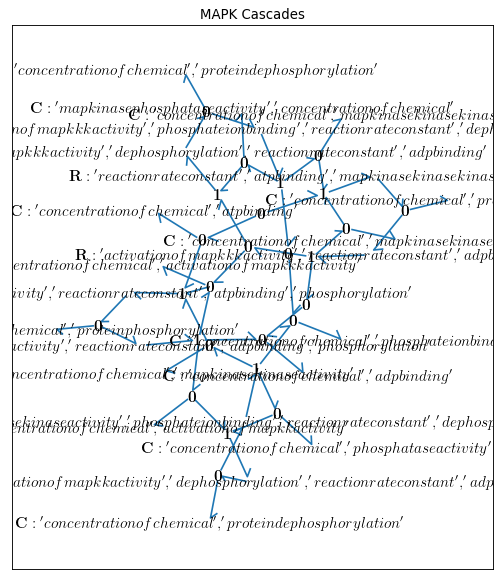

In [21]:
bgt.draw(model)

In [22]:
x0=[]
for s in range(len(list(model.state_vars.values()))):

    for j in range(len(list(stateVarsInitials[0]))):
        q=eval(list(stateVarsInitials[0])[j])
        if set(list(model.state_vars.values())[s][0].name) == set(q):
            x0.append(list(stateVarsInitials[0].values())[j])
    


In [23]:
# Combining the initial values of the state variables
def combineDict(dicts):
    incKey = 0
    newDict = {}
    for val in dicts:
        newDict['x_'+str(incKey)] = val 
        incKey+=1
    return newDict

In [24]:
x_0=combineDict(x0)

In [26]:
t_span = [0,1]
t, x = bgt.simulate(model, timespan=t_span, control_vars={}, x0=x_0, dt=0.001)

Text(0,0.5,'M concentration (mmol)')

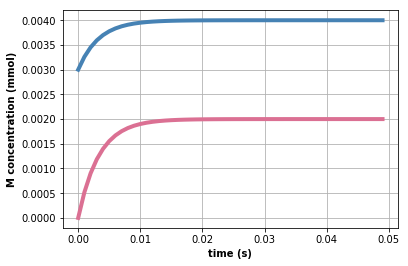

In [27]:
plt.plot(t[0:50],x[0:50,4],'steelblue', linewidth='4')
plt.plot(t[0:50],x[0:50,5],'palevioletred', linewidth='4')
plt.grid()
plt.xlabel('time (s)', fontweight='bold')
plt.ylabel('M concentration (mmol)', fontweight='bold')

Text(0,0.5,'MP concentration (mmol)')

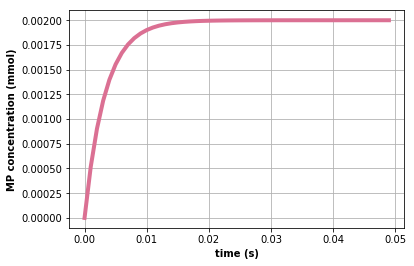

In [28]:
plt.plot(t[0:50],x[0:50,5],'palevioletred', linewidth='4')
plt.grid()
plt.xlabel('time (s)', fontweight='bold')
plt.ylabel('MP concentration (mmol)', fontweight='bold')